# Case study of uniaxial tensile tests

This is an example of how to use Paramaterial to process a dataset of uniaxial tensile test measurements.
The data should be formatted as a set of csv files containing measurements for each test, and a single excel spreadsheet containing the metadata for the dataset.
There should be a single row in the excel spreadsheet for each csv file.

The analysis takes 4 stages:
- Data preparation
- Data processing
- Model fitting
- Test report generation

## Modelling
We determine the material properties and fit a model to the transition region, following the process explained in the paper:

"Starting from a preload (which was chosen to be 30 lbf to minimize errors in the strain measurements caused by factors such as initial grip alignment), the upper proportional limit (UPL) is determined by linear regression as the point that minimizes the residuals of the slope fit between that point and the preload.

Then, starting from this UPL, the procedure was repeated in the opposite direction to obtain the lower proportional limit (LPL).

This procedure is automated and the proportional limits are consistently identified for all stress-strain curves using this criteria.

The elastic modulus is calculated as the slope of the best fit straight line between the upper and lower proportional limits.

Foot correction is applied to the stress-strain curve such that the linear elastic portion of the curve begins at the origin.

The 0.2% proof stress is then determined using this slope with an offset of 0.2% strain and is recorded as the yield stress and the corresponding strain is noted as the strain at yield.

From the upper proportional limit to the yield point, the Ramberg-Osgood model is fit to the data, and the fit parameter n is estimated by regression."

30 lbf of force is equivalent to 133.5 Newtons.

In [1]:

from typing import Callable

import numpy as np
from matplotlib import pyplot as plt

import paramaterial as pam
from paramaterial.plug import DataSet, DataItem

Input data.

In [2]:
processed_set = DataSet('data/02 processed data', 'info/02 processed info.xlsx').sort_by(['temperature', 'lot'])

Setup plotting.

In [29]:
styler = pam.plotting.Styler(
    color_by='temperature', cmap='plasma', color_by_label='(°C)', color_norm=plt.Normalize(20, 320),
    plot_kwargs=dict(grid=True))
styler.style_to(processed_set)


def ds_plot(ds: DataSet, **kwargs):
    return pam.plotting.dataset_plot(ds, styler=styler, **kwargs)


subplot_cfg = dict(
    shape=(3, 3), sharex='all', sharey='all', hspace=0.2,
    rows_by='lot', row_vals=[[a] for a in 'ABCDEFGHI'],
    cols_by='lot', col_vals=[[a] for a in 'ABCDEFGHI'],
    plot_titles=[f'Lot {a}' for a in 'ABCDEFGHI']
)


def ds_subplots(ds: DataSet, **kwargs):
    return pam.plotting.dataset_subplots(ds=ds, styler=styler, plot_legend=False, **subplot_cfg, **kwargs)


def subplot_wrapper(ds: DataSet, plot_func: Callable[[DataItem], DataItem], **plot_func_kwargs):
    return pam.plotting.subplot_wrapper(ds=ds, plot_func=plot_func, **subplot_cfg, **plot_func_kwargs)


stress_strain_labels = dict(x='Strain', y='Stress_MPa', ylabel='Stress (MPa)')

Plot input data.

### Make representative curves

In [9]:
pam.processing.make_representative_data(
    ds=trimmed_set, data_dir='data/02 representative data', info_path='info/02 representative info.xlsx',
    repr_col='Stress_MPa', repr_by_cols=['temperature', 'lot'], interp_by='Strain', interp_end='min_of_maxes'
)

NameError: name 'trimmed_set' is not defined

In [ ]:
repr_set = DataSet('data/02 representative data', 'info/02 representative info.xlsx', test_id_key='repr id')

ds_subplots(repr_set, x='interp_Strain', y='mean_Stress_MPa', fill_between=('min_Stress_MPa', 'max_Stress_MPa'),
            ylabel='Stress (MPa');

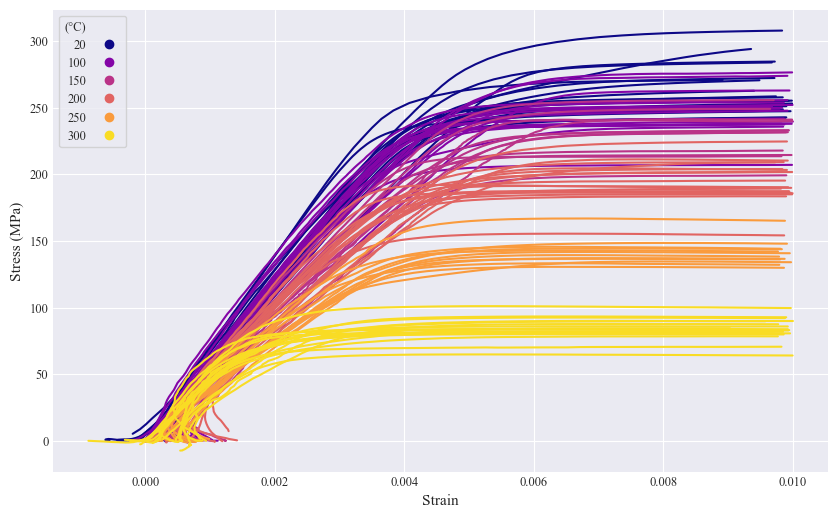

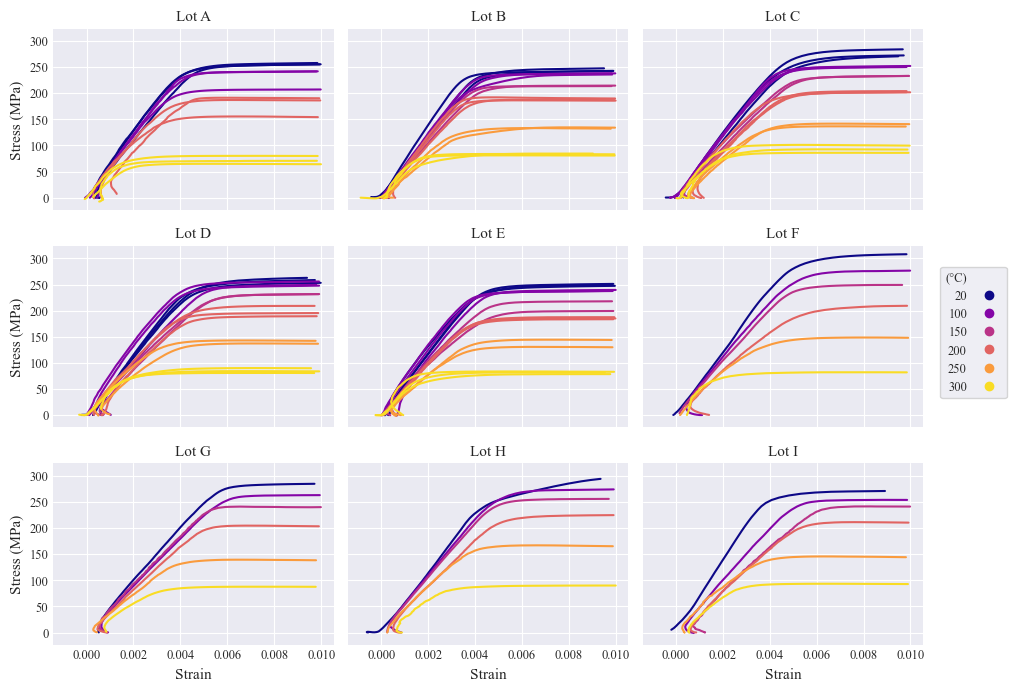

In [4]:
ds_plot(processed_set, **stress_strain_labels);
ds_subplots(processed_set, **stress_strain_labels);

### Write data for fitting

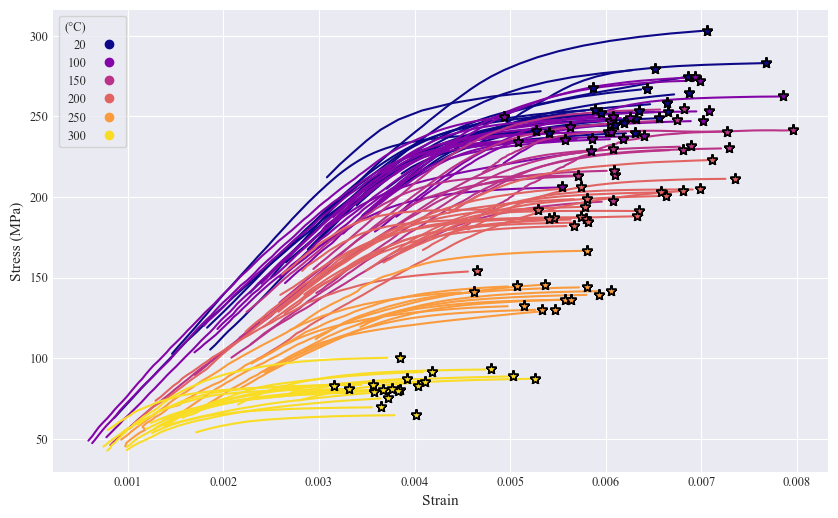

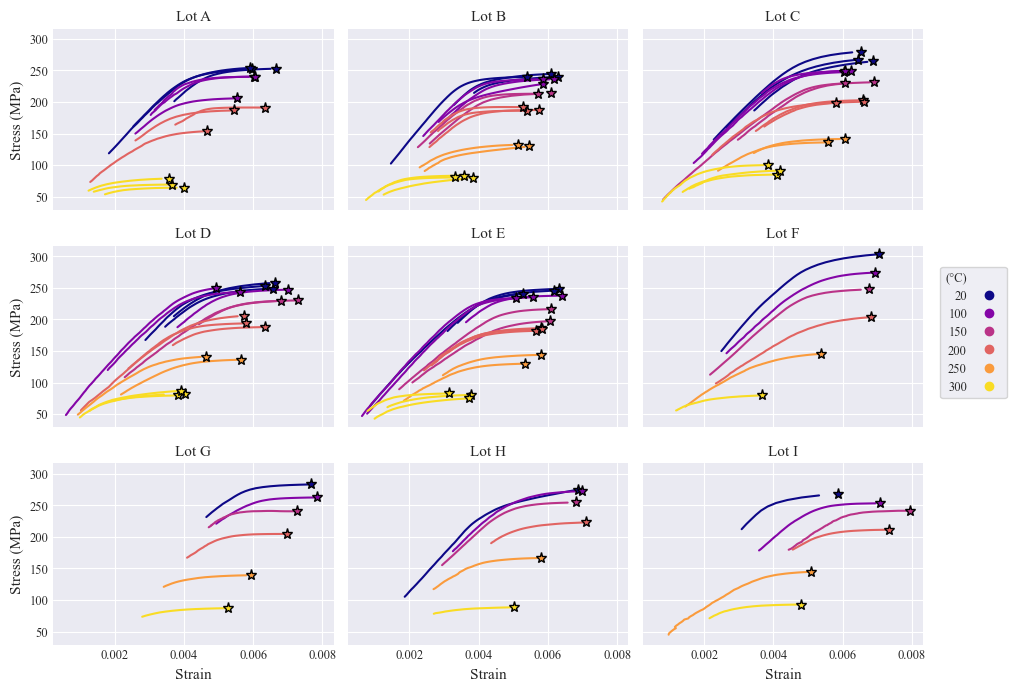

In [17]:
def trim_for_fitting(di):
    di.data = di.data[di.data['Stress_MPa'] > float(di.info['UPL_1'])]
    di.data = di.data[di.data['Strain'] < float(di.info['YP_0.002_0'])]
    return di

fitting_ds = proof_ds.apply(trim_for_fitting)
fitting_ds.write_output('data/02 fitting data', 'info/02 fitting info.xlsx')
pf_plots(fitting_ds);

array([[<AxesSubplot:title={'center':'Lot A'}, xlabel='x', ylabel='Stress (MPa)'>,
        <AxesSubplot:title={'center':'Lot B'}, xlabel='x', ylabel='Stress (MPa)'>,
        <AxesSubplot:title={'center':'Lot C'}, xlabel='x', ylabel='Stress (MPa)'>],
       [<AxesSubplot:title={'center':'Lot D'}, xlabel='x', ylabel='Stress (MPa)'>,
        <AxesSubplot:title={'center':'Lot E'}, xlabel='x', ylabel='Stress (MPa)'>,
        <AxesSubplot:title={'center':'Lot F'}, xlabel='x', ylabel='Stress (MPa)'>],
       [<AxesSubplot:title={'center':'Lot G'}, xlabel='x', ylabel='Stress (MPa)'>,
        <AxesSubplot:title={'center':'Lot H'}, xlabel='x', ylabel='Stress (MPa)'>,
        <AxesSubplot:title={'center':'Lot I'}, xlabel='x', ylabel='Stress (MPa)'>]],
      dtype=object)

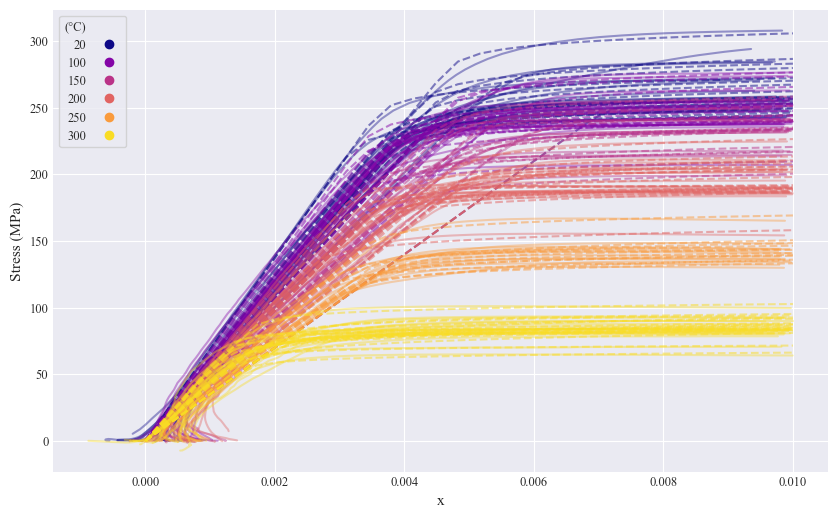

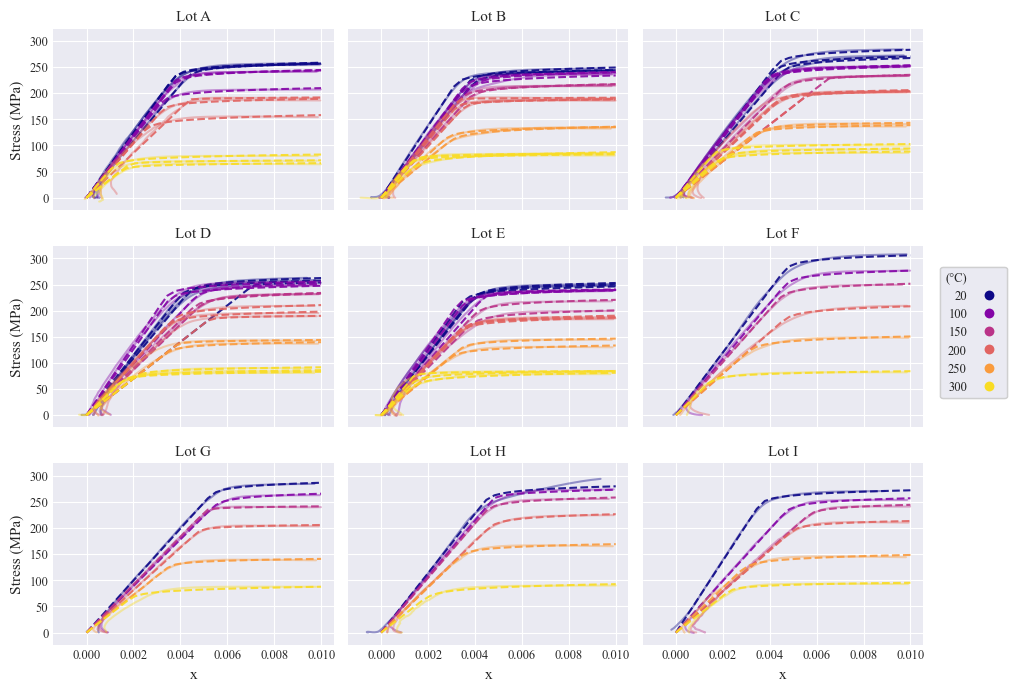

In [37]:
fitted_ds = DataSet('data/03 ramberg model data', 'info/03 ramberg model info.xlsx')

ax = ds_plot(foot2_ds, **stress_strain_labels, alpha=0.4);1
ds_plot(fitted_ds, x='x', y='y', alpha=0.5, ls='--', ax=ax);
axs = ds_subplots(foot2_ds, **stress_strain_labels, alpha=0.4);
ds_subplots(fitted_ds, x='x', y='y', alpha=0.9, ls='--', axs=axs);